In [1]:
import time
import numpy as np
import pandas as pd
import hydroeval as he
import json
import matplotlib.pyplot as plt
import sys

sys.path.insert(0, './CFE')
import bmi_cfe_open
import bmi_cfe_enkf_peturb

sys.path.insert(0, './Assimilation')
import Bmi_da_ENKF_forSBMI


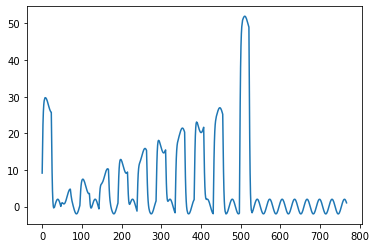

In [2]:
# GET OBSERVATIONS
cfe_obs = bmi_cfe_enkf_peturb.BMI_CFE()
cfe_obs.initialize(cfg_file='./CFE/config_cfe_synthetic.json')
with open(cfe_obs.forcing_file, 'r') as f:
    df_forcing = pd.read_csv(f)
OBSERVATIONS_LIST = []
for i, precip in enumerate(df_forcing['APCP_surface']): #i is RAINRATE
    cfe_obs.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip) 
    cfe_obs.update()
    OBSERVATIONS_LIST.append(cfe_obs.get_value('land_surface_water__runoff_depth') + np.sin(i/5) * 2)
cfe_obs.finalize()
plt.plot(OBSERVATIONS_LIST)

In [3]:
## Open BMI's for each file
#cfe_open = bmi_cfe_open.BMI_CFE()
cfe_open = bmi_cfe_enkf_peturb.BMI_CFE() #One BMI to rule them all
cfe_peturbed = bmi_cfe_enkf_peturb.BMI_CFE()
cfe_analysis = bmi_cfe_enkf_peturb.BMI_CFE() #true model in the end with updated state vars

enkf = Bmi_da_ENKF_forSBMI.EnKF_wrap()

In [4]:
print(bmi_cfe_open)
print(bmi_cfe_enkf_peturb)
print(Bmi_da_ENKF_forSBMI)

<module 'bmi_cfe_open' from 'C:\\Users\\zjbut\\Documents\\GitHub\\NextGen---The-Simulators-\\Toy_Model\\./CFE\\bmi_cfe_open.py'>
<module 'bmi_cfe_enkf_peturb' from 'C:\\Users\\zjbut\\Documents\\GitHub\\NextGen---The-Simulators-\\Toy_Model\\./CFE\\bmi_cfe_enkf_peturb.py'>
<module 'Bmi_da_ENKF_forSBMI' from 'C:\\Users\\zjbut\\Documents\\GitHub\\NextGen---The-Simulators-\\Toy_Model\\./Assimilation\\Bmi_da_ENKF_forSBMI.py'>


In [5]:

# ## Case study files
cfe_open.initialize(cfg_file='./CFE/config_cfe_synthetic.json')
cfe_peturbed.initialize(cfg_file='./CFE/config_cfe_synthetic.json')
cfe_analysis.initialize(cfg_file='./CFE/config_cfe_synthetic.json')
enkf.initialize(cfg_file='./Assimilation/EnKF_config-synthetic.json') # Need to create this still

initialized 10


                time  APCP_surface      T2D       Q2D     U2D     V2D  \
0     5/15/2017 0:00            10  284.078  0.006616  6.0804 -1.9670   
1     5/15/2017 1:00            10  283.180  0.006650  6.0304 -2.0740   
2     5/15/2017 2:00            10  282.440  0.006614  5.9856 -2.1828   
3     5/15/2017 3:00            10  281.662  0.006476  5.9402 -2.2888   
4     5/15/2017 4:00            10  281.702  0.006530  6.3688 -2.5458   
..               ...           ...      ...       ...     ...     ...   
763  6/15/2017 19:00             0  295.270  0.007334 -1.1600  4.5018   
764  6/15/2017 20:00             0  294.610  0.006788 -1.2230  4.4990   
765  6/15/2017 21:00             0  293.624  0.006776 -1.2812  4.4996   
766  6/15/2017 22:00             0  292.722  0.006714 -1.5682  3.8524   
767  6/15/2017 23:00             0  291.554  0.006650 -1.8486  3.1996   

          PSFC   SWDOWN   LWDOWN  
0     98376.98    0.000  318.822  
1     98378.60    0.000  317.996  
2     98380.28    

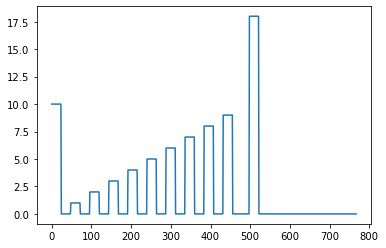

In [6]:
with open(cfe_open.forcing_file, 'r') as f:
    df_forcing = pd.read_csv(f)
    
print(df_forcing)
plt.plot(df_forcing['APCP_surface'])

values = df_forcing['APCP_surface']
print(values)

In [7]:
#Make empty matrices for plotting
cfeOpen = []
cfePeturbed = []
cfeAnalysis = []
cfeEnKF = []

## Loop through time. Set values for each model and get values
for i, precip in enumerate(df_forcing['APCP_surface']): #i is RAINRATE

    # Set values for each model
    cfe_open.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip) #value of precip from forcing data in loop
    cfe_peturbed.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip)
    cfe_analysis.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip)
    
    obs = OBSERVATIONS_LIST[i]
    enkf.set_value('validity', 1)
    
    # Update CFE open and peturbed. Get value for peturbed stats. 
    cfe_open.update()
    cfe_peturbed.update()
    
    # Get state vars from Peturbed. These are values as enkf uses
    soil_storage_avail = cfe_peturbed.get_value('soil_storage_avail_m')
    soil_reservoir_storage_deficit = cfe_peturbed.get_value('soil_reservoir_storage_deficit_out_m')
    surface_runoff = cfe_peturbed.get_value('land_surface_water__runoff_volume_flux')
   
    # Get values for plotting
    outflow = cfe_open.get_value('land_surface_water__runoff_depth')
    cfeOpen.append(outflow) #for plotting
    outflow_peturb = cfe_peturbed.get_value('land_surface_water__runoff_depth_ens')
    
    # Get mean and covariance for stats of ensemble runs for EnKF
    outflow_peturb_mean = np.mean(outflow_peturb)
    outflow_peturb_covar = np.cov(outflow_peturb)
    cfePeturbed.append(outflow_peturb_mean) # For plotting
    
    # Set EnKF value to usgs, mean, and covariance. Get value from it then update
    enkf.set_value('soil_storage_avail_m', soil_storage_avail) #setting soil storage in enkf
    enkf.set_value('soil_reservoir_storage_deficit_m', soil_reservoir_storage_deficit) #setting soil storage in enkf
    enkf.set_value('surface_runoff_depth_m', surface_runoff) #setting soil storage in enkf
    
    enkf.set_value('x', np.array([outflow_peturb_mean]))
    enkf.set_value('P', np.array([outflow_peturb_covar]))
    enkf.set_value('z', np.array([obs]))
    enkf.update()
    
    # For plotting
    outflow_enkf = enkf.get_value('enkf')
    cfeEnKF.append(outflow_enkf)
    
    # Get new EnKF state vars to give back to CFE Analysis
    state_transition_soil_storage = enkf.get_value('soil_storage_avail_m')
    state_transition_soil_res     = enkf.get_value('soil_reservoir_storage_deficit_updated_m')
    state_transition_runoff_factor= enkf.get_value('surface_runoff_ratio')
    
    # Set value for CFE analysis based on the state variable change from the EnKF factor to get true streamflow
    cfe_analysis.set_value('soil_storage_avail_m', state_transition_soil_storage)    
    cfe_analysis.set_value('soil_reservoir_storage_deficit_m', state_transition_soil_res)  
    cfe_analysis.set_value('state_var_change_runoff',state_transition_runoff_factor)
    cfe_analysis.update() #get new streamflow value based on state var change
    
    # For plotting
    outflow_analysis = cfe_analysis.get_value('land_surface_water__runoff_depth')
    cfeAnalysis.append(outflow_analysis) 
        
    # Get values from new CFE analysis to put back into CFE Peturbed to keep look and EnKF going
    cfe_updated_everything_soil_storage = cfe_analysis.get_value('soil_storage_avail_m')
    cfe_updated_everything_soil_res = cfe_analysis.get_value('soil_reservoir_storage_deficit_m')
    cfe_updated_everything_runoff = cfe_analysis.get_value('state_var_change_runoff')
    
    # Set value from CFE analysis state variables back into CFE Peturbed to continue EnKF loop
    cfe_peturbed.set_value('soil_storage_avail_m', cfe_updated_everything_soil_storage)
    cfe_peturbed.set_value('soil_reservoir_storage_deficit_m', cfe_updated_everything_soil_res)
    cfe_peturbed.set_value('state_var_change_runoff', cfe_updated_everything_runoff)
    
# # Finalize models
cfe_open.finalize(print_mass_balance=True)
cfe_peturbed.finalize(print_mass_balance=True)
cfe_analysis.finalize(print_mass_balance=True)
enkf.finalize()

F2 is 10000 1.0
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.3121136221931379
EnKF Code predicted, X Post [9.32466655]
***********under estimaiton ratio [1.36278174]
Observation BMI [9.14803171]
CFE [6.84237707]
enkf [9.32466655]
F2 is 10000 1.0
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.29574402771625197
EnKF Code predicted, X Post [16.52327413]
***********under estimaiton ratio [1.17764286]
Observation BMI [16.75252741]
CFE [14.03080228]
enkf [16.52327413]
F2 is 10000 1.0
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.28078702857362736
EnKF Code predicted, X Post [22.91683489]
surface_runoff_ratio [2.03434361]
Leftover vol 0.0
surface _runoff [2.03434361]
***********over estimaiton ratio [1.]
Observation BMI [22.40183725]
CFE [24.29737159]
enkf [22.91683489]
F2 is 10000 1.0
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2671209606679281
EnKF Co

EnKF Code predicted, X Post [0.29145743]
***********under estimaiton ratio [23.56499175]
Observation BMI [0.83307684]
CFE [0.01236824]
enkf [0.29145743]
F2 is 10000 1.0
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2981745526655525
EnKF Code predicted, X Post [0.07574865]
***********under estimaiton ratio [9.77220056]
Observation BMI [0.45479685]
CFE [0.00775144]
enkf [0.07574865]
F2 is 10000 1.0
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.3039379968173769
EnKF Code predicted, X Post [0.03130215]
***********under estimaiton ratio [3.38940607]
Observation BMI [0.05874039]
CFE [0.00923529]
enkf [0.03130215]
F2 is 10000 1.0
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.30960775909673466
EnKF Code predicted, X Post [2.50462272]
surface_runoff_ratio [0.23983418]
Leftover vol 0.0
surface _runoff [0.23983418]
***********over estimaiton ratio [1.]
Observation BMI [0.55751944]
CFE [3.88927

F2 is 10000 1.0
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.3104445961688789
EnKF Code predicted, X Post [2.32901077]
surface_runoff_ratio [1.55806585]
Leftover vol 0.0
surface _runoff [1.55806585]
***********over estimaiton ratio [1.]
Observation BMI [2.51593548]
CFE [13.2004222]
enkf [2.32901077]
F2 is 10000 1.0
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2944103730214862
EnKF Code predicted, X Post [4.82442243]
surface_runoff_ratio [1.37054755]
Leftover vol 0.0
surface _runoff [1.37054755]
***********over estimaiton ratio [1.]
Observation BMI [4.30511966]
CFE [16.900174]
enkf [4.82442243]
F2 is 10000 1.0
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.27974068972008115
EnKF Code predicted, X Post [6.85829367]
surface_runoff_ratio [1.15283213]
Leftover vol 0.0
surface _runoff [1.15283213]
***********over estimaiton ratio [1.]
Observation BMI [5.66870066]
CFE [12.9633985]
enkf [6

surface_runoff_ratio [0.31956761]
Leftover vol 0.0
surface _runoff [0.31956761]
***********over estimaiton ratio [1.]
Observation BMI [4.7981756]
CFE [4.19547911]
enkf [3.81795858]
F2 is 10000 1.0
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.16079119965849165
EnKF Code predicted, X Post [2.76542361]
***********under estimaiton ratio [1.53270954]
Observation BMI [2.904415]
CFE [1.80427115]
enkf [2.76542361]
F2 is 10000 1.0
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.16878774079475933
EnKF Code predicted, X Post [0.87478488]
***********under estimaiton ratio [1.05198639]
Observation BMI [1.63276266]
CFE [0.83155532]
enkf [0.87478488]
F2 is 10000 1.0
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.17665430219544398
EnKF Code predicted, X Post [0.76889096]
***********under estimaiton ratio [1.89631754]
Observation BMI [0.74839529]
CFE [0.4054653]
enkf [0.76889096]
F2 is 10000 1.0
Begin

surface _runoff [0.90161014]
***********over estimaiton ratio [1.]
Observation BMI [10.77593092]
CFE [14.86699161]
enkf [10.82908496]
F2 is 10000 1.0
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.17570510778825255
EnKF Code predicted, X Post [10.2456032]
***********under estimaiton ratio [1.09682719]
Observation BMI [10.3910927]
CFE [9.341128]
enkf [10.2456032]
F2 is 10000 1.0
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.17113811095462617
EnKF Code predicted, X Post [10.01871983]
surface_runoff_ratio [0.90782977]
Leftover vol 0.0
surface _runoff [0.90782977]
***********over estimaiton ratio [1.]
Observation BMI [10.03419432]
CFE [13.91172367]
enkf [10.01871983]
F2 is 10000 1.0
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.1669646269907622
EnKF Code predicted, X Post [9.68472106]
surface_runoff_ratio [0.89774512]
Leftover vol 0.0
surface _runoff [0.89774512]
***********over estimait

EnKF Code predicted, X Post [0.11840072]
***********under estimaiton ratio [5.24104102]
Observation BMI [-1.3411508]
CFE [0.02259107]
enkf [0.11840072]
F2 is 10000 1.0
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2614462777887627
EnKF Code predicted, X Post [-0.18610144]
surface_runoff_ratio [0.00158687]
Leftover vol 0.0
surface _runoff [0.00158687]
***********over estimaiton ratio [1.]
Observation BMI [-1.02292809]
CFE [0.02524329]
enkf [-0.18610144]
F2 is 10000 1.0
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2678067214902119
EnKF Code predicted, X Post [-0.36133369]
surface_runoff_ratio [0.00158649]
Leftover vol 0.0
surface _runoff [0.00158649]
***********over estimaiton ratio [1.]
Observation BMI [-0.66312295]
CFE [0.0213431]
enkf [-0.36133369]
F2 is 10000 1.0
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2740637793931744
EnKF Code predicted, X Post [-0.00947809]
surface_runof

CFE [24.45988928]
enkf [20.66263418]
F2 is 10000 1.0
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.17542045090307012
EnKF Code predicted, X Post [21.1321097]
surface_runoff_ratio [1.59586561]
Leftover vol 0.0
surface _runoff [1.59586561]
***********over estimaiton ratio [1.]
Observation BMI [20.97571803]
CFE [24.37209247]
enkf [21.1321097]
F2 is 10000 1.0
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.17086147700326348
EnKF Code predicted, X Post [21.09454422]
***********under estimaiton ratio [1.41916259]
Observation BMI [21.19755278]
CFE [14.86407853]
enkf [21.09454422]
F2 is 10000 1.0
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.16669617250338864
EnKF Code predicted, X Post [20.55749401]
***********under estimaiton ratio [1.07829744]
Observation BMI [21.3487926]
CFE [19.06477115]
enkf [20.55749401]
F2 is 10000 1.0
Beginning----------------------------
self.f 1.0
soil_storage_defi

Observation BMI [1.72756038]
CFE [0.02043139]
enkf [1.30540209]
F2 is 10000 1.0
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.23481887451407102
EnKF Code predicted, X Post [0.27100164]
***********under estimaiton ratio [14.66971323]
Observation BMI [1.48659762]
CFE [0.01847355]
enkf [0.27100164]
F2 is 10000 1.0
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.24161213320114094
EnKF Code predicted, X Post [0.2978439]
***********under estimaiton ratio [12.71279052]
Observation BMI [1.18717256]
CFE [0.02342868]
enkf [0.2978439]
F2 is 10000 1.0
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.24829497090083075
EnKF Code predicted, X Post [-0.22595568]
surface_runoff_ratio [0.00159078]
Leftover vol 0.0
surface _runoff [0.00159078]
***********over estimaiton ratio [1.]
Observation BMI [0.84122239]
CFE [0.01877905]
enkf [-0.22595568]
F2 is 10000 1.0
Beginning----------------------------
self.f 1

EnKF Code predicted, X Post [-0.49174836]
surface_runoff_ratio [0.00154669]
Leftover vol 0.0
surface _runoff [0.00154669]
***********over estimaiton ratio [1.]
Observation BMI [-1.12710062]
CFE [0.0189538]
enkf [-0.49174836]
F2 is 10000 1.0
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.36604817262313893
EnKF Code predicted, X Post [-0.21402226]
surface_runoff_ratio [0.00154202]
Leftover vol 0.0
surface _runoff [0.00154202]
***********over estimaiton ratio [1.]
Observation BMI [-1.42983601]
CFE [0.02042753]
enkf [-0.21402226]
F2 is 10000 1.0
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.3707083653785387
EnKF Code predicted, X Post [-1.18786638]
surface_runoff_ratio [0.00153712]
Leftover vol 0.0
surface _runoff [0.00153712]
***********over estimaiton ratio [1.]
Observation BMI [-1.67478965]
CFE [0.01900113]
enkf [-1.18786638]
F2 is 10000 1.0
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE

F2 is 10000 1.0
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.3851201084408814
EnKF Code predicted, X Post [-0.28492179]
surface_runoff_ratio [0.00142408]
Leftover vol 0.0
surface _runoff [0.00142408]
***********over estimaiton ratio [1.]
Observation BMI [-1.76188686]
CFE [0.01519406]
enkf [-0.28492179]
F2 is 10000 1.0
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.38947029651645726
EnKF Code predicted, X Post [-0.90994192]
surface_runoff_ratio [0.00141974]
Leftover vol 0.0
surface _runoff [0.00141974]
***********over estimaiton ratio [1.]
Observation BMI [-1.54528655]
CFE [0.01790383]
enkf [-0.90994192]
F2 is 10000 1.0
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.3937497744829791
EnKF Code predicted, X Post [-0.78810408]
surface_runoff_ratio [0.00141519]
Leftover vol 0.0
surface _runoff [0.00141519]
***********over estimaiton ratio [1.]
Observation BMI [-1.26636358]
CFE [0.01757917

F2 is 10000 1.0
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.5691491326597761
EnKF Code predicted, X Post [0.56796191]
***********under estimaiton ratio [65.64129642]
Observation BMI [1.03259474]
CFE [0.00865251]
enkf [0.56796191]
F2 is 10000 1.0
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.5705080219350369
EnKF Code predicted, X Post [0.58381582]
***********under estimaiton ratio [66.49364855]
Observation BMI [1.35366528]
CFE [0.00878002]
enkf [0.58381582]
F2 is 10000 1.0
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.5718448231517641
EnKF Code predicted, X Post [0.28283667]
***********under estimaiton ratio [29.148503]
Observation BMI [1.62119147]
CFE [0.0097033]
enkf [0.28283667]
F2 is 10000 1.0
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.5731598953401881
EnKF Code predicted, X Post [0.49617665]
***********under estimaiton ratio [45.08943387]

EnKF Code predicted, X Post [0.20813914]
***********under estimaiton ratio [45.68217019]
Observation BMI [1.08632104]
CFE [0.00455624]
enkf [0.20813914]
F2 is 10000 1.0
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.6278880297604456
EnKF Code predicted, X Post [0.53173908]
***********under estimaiton ratio [117.44135748]
Observation BMI [0.73053104]
CFE [0.0045277]
enkf [0.53173908]
F2 is 10000 1.0
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.6282921479436201
EnKF Code predicted, X Post [-0.0362951]
surface_runoff_ratio [0.00032485]
Leftover vol 0.0
surface _runoff [0.00032485]
***********over estimaiton ratio [1.]
Observation BMI [0.34578477]
CFE [0.00453631]
enkf [-0.0362951]
F2 is 10000 1.0
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.6286896973899248
EnKF Code predicted, X Post [-0.12933276]
surface_runoff_ratio [0.00032031]
Leftover vol 0.0
surface _runoff [0.00032031]
*******

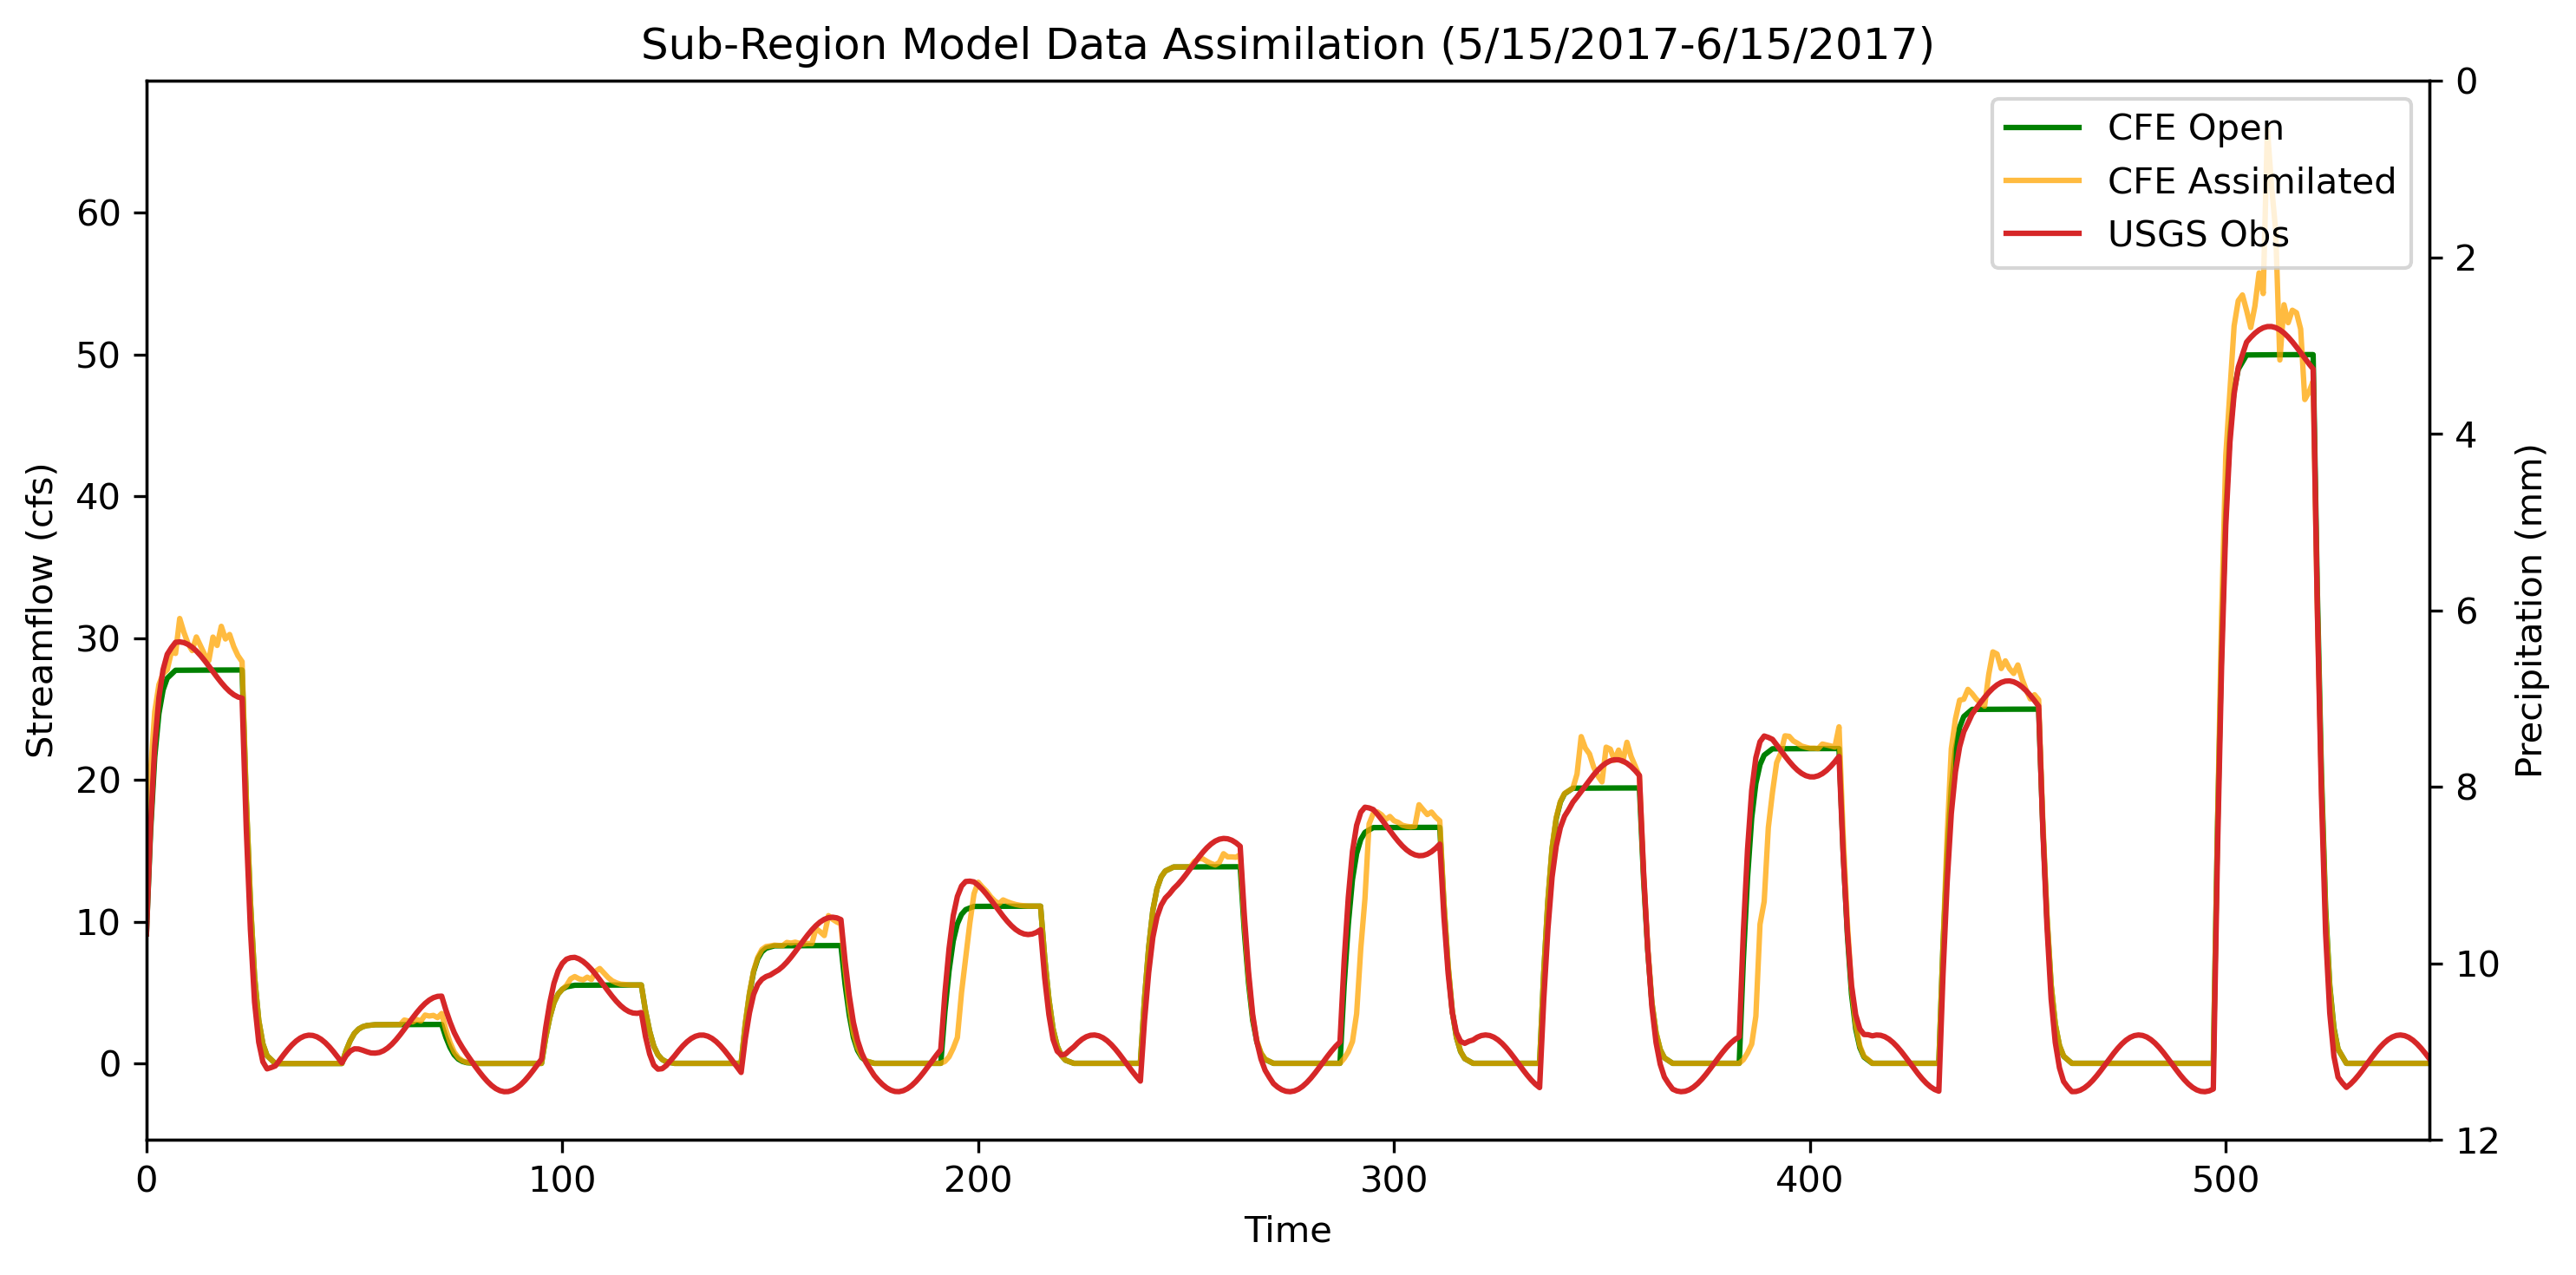

In [8]:
istart_plot=0
iend_plot=550
x = list(range(istart_plot, iend_plot))

fig, ax1 = plt.subplots(figsize = (10,5), dpi=300)

ax2 = ax1.twinx()

ax1.set_xlabel('Time')
ax1.set_ylabel('Streamflow (cfs)')
ax2.set_ylabel('Precipitation (mm)')
ax2.set_ylim(0,12,1)
ax2.invert_yaxis()
#ax1.set_ylim(0,50,1)

plt.title('Sub-Region Model Data Assimilation (5/15/2017-6/15/2017)')
#Precip = ax2.bar(x, df_forcing['APCP_surface'][istart_plot:iend_plot],width=1,alpha=0.7, color="tab:blue", label = 'Precip')
#ax1.plot(x, cfePeturbed[istart_plot:iend_plot], color = 'tab:orange', label = 'CFE Peturbed')
Open, = ax1.plot(x, cfeOpen[istart_plot:iend_plot], color = 'green', label = 'CFE Open')
Analysis, = ax1.plot(x, cfeAnalysis[istart_plot:iend_plot], color = 'orange', alpha=0.75, label = 'CFE Assimilated')
Obs, = ax1.plot(x, OBSERVATIONS_LIST[istart_plot:iend_plot], color = 'tab:red', label = 'USGS Obs')
#ax1.plot(x, cfeEnKF[istart_plot:iend_plot], color = 'tab:blue', label = 'EnKF')

plt.legend(handles = [Open,Analysis,Obs], loc='upper right', bbox_to_anchor=(0.5, 0.5, 0.5, 0.5))

#plt.savefig("WorkingDA_7-19.png")
fig.tight_layout()
ax1.margins(x=0)

plt.show()


In [9]:
df=pd.DataFrame({"obs":OBSERVATIONS_LIST,"cfeAnalysis":cfeAnalysis,"cfeOpen":cfeOpen})
df.dropna(axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)
df

,obs,cfeAnalysis,cfeOpen
0,9.148032,12.466126,9.148032
1,16.752527,20.594401,16.355189
2,22.401837,24.813687,21.623001
3,25.803301,26.715628,24.674016
4,27.774125,27.484355,26.339413
...,...,...,...
763,1.947856,0.001788,0.001788
764,1.817387,0.001761,0.001761
765,1.614535,0.001734,0.001734
766,1.347387,0.001708,0.001708


In [10]:
# CFE open eval
nse_open=he.evaluator(he.nse,df["obs"],df["cfeOpen"])
pbias=he.evaluator(he.pbias,df["obs"],df["cfeOpen"])
kge_open, r_open, alpha_open, beta_open = he.evaluator(he.kge, df["obs"],df["cfeOpen"])
print("r_open=",r_open[0])
print("KGE_open=",kge_open[0])
print("NSE_open=", nse_open[0])
print("PBias=", pbias[0])

# CFE Analysis
nse_analysis=he.evaluator(he.nse,df["obs"],df["cfeAnalysis"])
pbias_analysis=he.evaluator(he.pbias,df["obs"],df["cfeAnalysis"])
kge_analysis, r_analysis, alpha_analysis, beta_analysis = he.evaluator(he.kge, df["obs"],df["cfeAnalysis"])
print("r_analysis=",r_analysis[0])
print("KGE_analysis=",kge_analysis[0])
print("NSE_analysis=", nse_analysis[0])
print("PBias=", pbias_analysis[0])

print("mean_obs=",np.mean(df["obs"]))
print("STD_obs=",np.std(df["obs"]))
print("mean_open=",np.mean(df["cfeOpen"]))
print("STD_open=",np.std(df["cfeOpen"]))
print("mean_analysis=",np.mean(df["cfeAnalysis"]))
print("STD_analysis=",np.std(df["cfeAnalysis"]))

r_open= 0.9918810222171683
KGE_open= 0.9801868200997844
NSE_open= 0.9831590133165918
PBias= -0.391113872588313
r_analysis= 0.9788492429844986
KGE_analysis= 0.9495719115691471
NSE_analysis= 0.9576016259304857
PBias= 1.7298130291155542
mean_obs= 6.3627240917724786
STD_obs= 11.100242637718
mean_open= 6.3379355466139655
STD_open= 10.907774564107545
mean_analysis= 6.474724723641394
STD_analysis= 11.591539659768706
